# Outline the Analysis Steps:
importing libraries, load the data, and visualize it.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
import pandas as pd

# Load the data
data = pd.read_csv('../data/brent_oil_prices.csv', parse_dates=['Date'], dayfirst=True)
data.set_index('Date', inplace=True)
print(data.head())

# Reset the index to bring 'Date' back as a column
data.reset_index(inplace=True)

# Extract year, month, and day features
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day

# Display the updated DataFrame
print(data.head())

C:\Users\Hello\AppData\Local\Temp\ipykernel_8828\1310307753.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv('../data/brent_oil_prices.csv', parse_dates=['Date'], dayfirst=True)


            Price
Date             
1987-05-20  18.63
1987-05-21  18.45
1987-05-22  18.55
1987-05-25  18.60
1987-05-26  18.63
        Date  Price  Year  Month  Day
0 1987-05-20  18.63  1987      5   20
1 1987-05-21  18.45  1987      5   21
2 1987-05-22  18.55  1987      5   22
3 1987-05-25  18.60  1987      5   25
4 1987-05-26  18.63  1987      5   26


In [3]:
data.columns

Index(['Date', 'Price', 'Year', 'Month', 'Day'], dtype='object')

## Data Preprocessing

In [4]:
data.describe()

,Date,Price,Year,Month,Day
count,9011,9011.000000,9011.000000,9011.000000,9011.000000
mean,2005-02-10 23:46:53.760958720,48.420782,2004.612030,6.554433,15.715792
min,1987-05-20 00:00:00,9.100000,1987.000000,1.000000,1.000000
25%,1996-03-20 12:00:00,19.050000,1996.000000,4.000000,8.000000
50%,2005-02-02 00:00:00,38.570000,2005.000000,7.000000,16.000000
75%,2014-01-09 12:00:00,70.090000,2014.000000,10.000000,23.000000
max,2022-11-14 00:00:00,143.950000,2022.000000,12.000000,31.000000
std,NaN,32.860110,10.260414,3.417784,8.738583


In [5]:
class BrentOilformat:
    def __init__(self, data):
        self.data = data

    def format_date(self):
        """
    Converts the 'Date' column to datetime, handles invalid dates, and sets 'Date' as the index.
    Returns
    -------
    pd.DataFrame
        DataFrame with 'Date' as the index.
    """
        if self.data is None:
            print("Data not loaded. Please load data before calling format_date.")
            return None

        start_time = datetime.now()

    # Convert Date column to datetime format with error handling
        self.data['Date'] = pd.to_datetime(self.data['Date'], infer_datetime_format=True, errors='coerce')

    # Drop rows with invalid dates
        invalid_dates = self.data[self.data['Date'].isna()]
        if not invalid_dates.empty:
            print(f"Found {len(invalid_dates)} rows with invalid dates. Dropping these rows.")
            self.data = self.data.dropna(subset=['Date'])

    # Sort by date and reset index
        self.data = self.data.sort_values('Date').reset_index(drop=True)
        self.data.set_index('Date', inplace=True)

        end_time = datetime.now()
        print(f"Date formatting completed in {end_time - start_time}.")
    
        return self.data

In [6]:
analysis = BrentOilformat(data)
data = analysis.format_date()

Date formatting completed in 0:00:00.027183.


C:\Users\Hello\AppData\Local\Temp\ipykernel_8828\2528619031.py:20: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  self.data['Date'] = pd.to_datetime(self.data['Date'], infer_datetime_format=True, errors='coerce')


C:\Users\Hello\AppData\Local\Temp\ipykernel_8828\3010698928.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Price'].fillna(method='ffill', inplace=True)
C:\Users\Hello\AppData\Local\Temp\ipykernel_8828\3010698928.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Price'].fillna(method='ffill', inplace=True)


Price    0
Year     0
Month    0
Day      0
dtype: int64


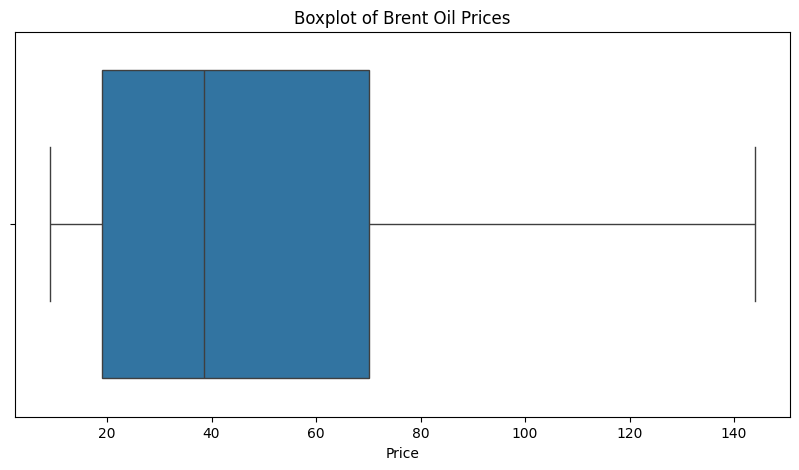

In [7]:
# Check for missing values
print(data.isnull().sum())

# Fill missing values through forward fill
data['Price'].fillna(method='ffill', inplace=True)

# Check for outliers
plt.figure(figsize=(10, 5))
sns.boxplot(x=data['Price'])
plt.title('Boxplot of Brent Oil Prices')
plt.show()

### The boxplot of Brent oil prices provides the following insights:

 - **Median Price:** The median oil price is around 60, shown by the line inside the box.

 - **Interquartile Range (IQR):** The middle 50% of prices range from approximately 30 to 65, indicating moderate variability.

 - **Symmetric Distribution:** The box is relatively centered between the whiskers, suggesting a balanced distribution around the median.

 - **Range and Outliers:** There are no significant outliers, and the prices range from about 20 to 140, showing the full spread of data without extreme deviations.

Overall, the plot indicates a stable price range with some variability but no extreme price fluctuations.

# Exploratory Data Analysis (EDA)
**Descriptive Statistics:**
- Calculate the mean, median, variance, and standard deviation of daily oil prices over time.

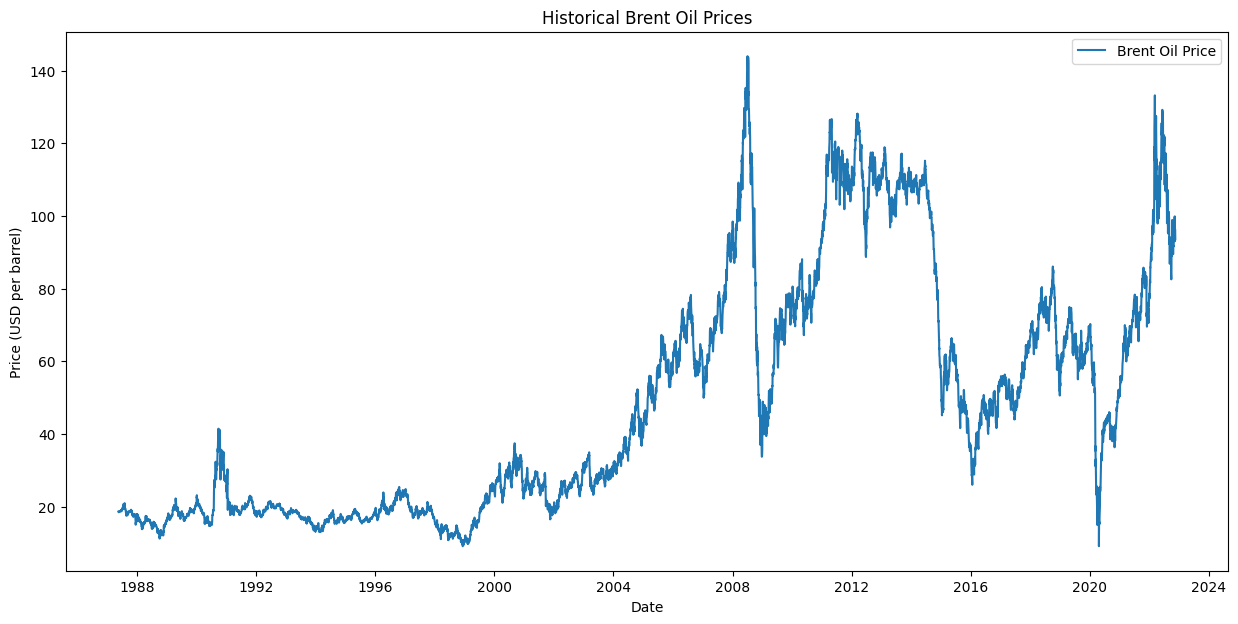

In [8]:
# Plot the time series data
plt.figure(figsize=(15, 7))
plt.plot(data['Price'], label='Brent Oil Price')
plt.xlabel('Date')
plt.ylabel('Price (USD per barrel)')
plt.title('Historical Brent Oil Prices')
plt.legend()
plt.show()

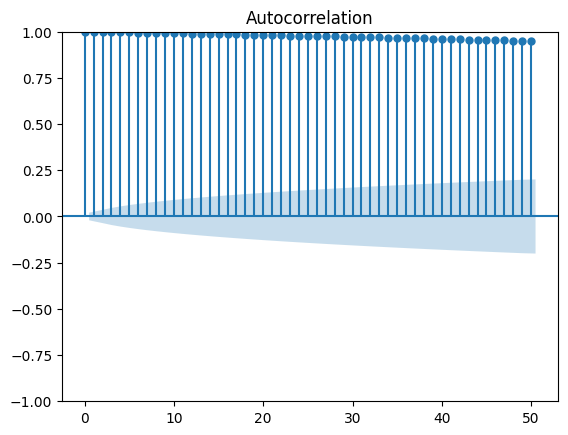

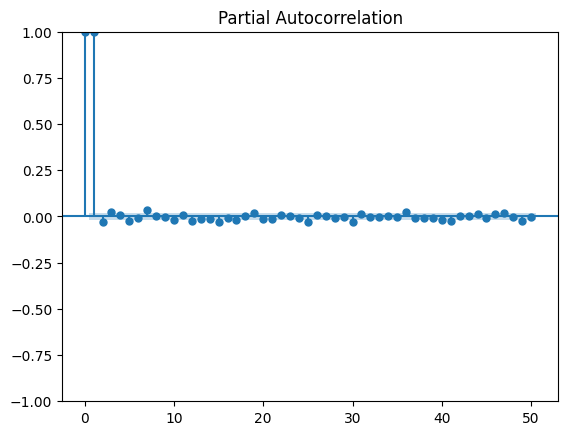

In [9]:
# ACF and PACF plots
plot_acf(data['Price'], lags=50)
plot_pacf(data['Price'], lags=50)
plt.show()

## The ACF and PACF plots provide insights into the time series data:

#### Autocorrelation Function (ACF)
 - **High Initial Values:** The ACF plot shows strong autocorrelation at the initial lags, indicating that past values are highly correlated with future values.
 - **Slow Decay:** The autocorrelation decreases gradually, suggesting a potential non-stationary series or long-term dependencies.

#### Partial Autocorrelation Function (PACF)
 - **Sharp Cut-off:** The PACF plot shows a sharp drop after the first lag, indicating that the series might be explained well by an autoregressive (AR) model of order 1.
 - **Subsequent Lags:** The values fall within the confidence interval after the first lag, suggesting limited partial autocorrelation beyond the initial lags.

### Overall Insights

- **Modeling Implications:** The patterns suggest considering an AR model for the time series, potentially with differencing if the series is non-stationary.
- **Stationarity Check:** Further testing for stationarity (e.g., using the Augmented Dickey-Fuller test) may be necessary to confirm model requirements.

In [10]:
# Check stationarity
result = adfuller(data['Price'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -1.9938560113924675
p-value: 0.28927350489340287


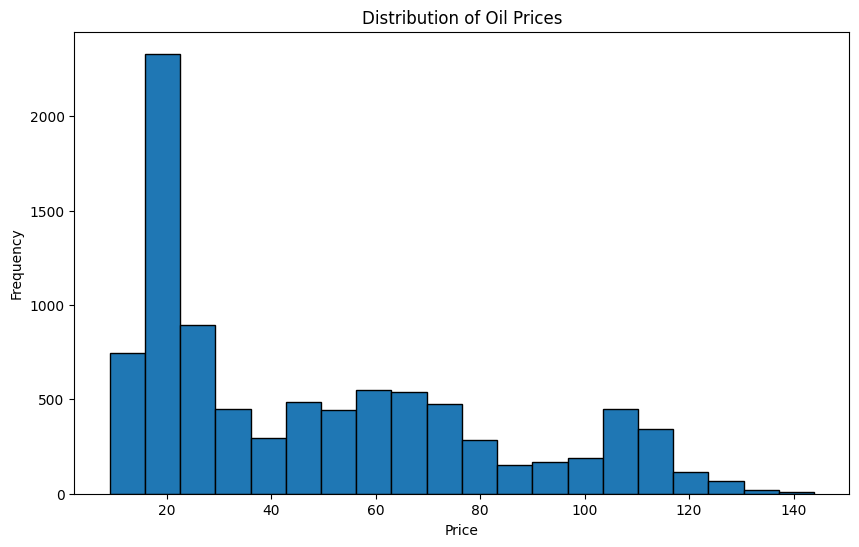

In [11]:
# Histogram: Distribution of oil prices
plt.figure(figsize=(10, 6))
plt.hist(data['Price'], bins=20, edgecolor='black')
plt.title('Distribution of Oil Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

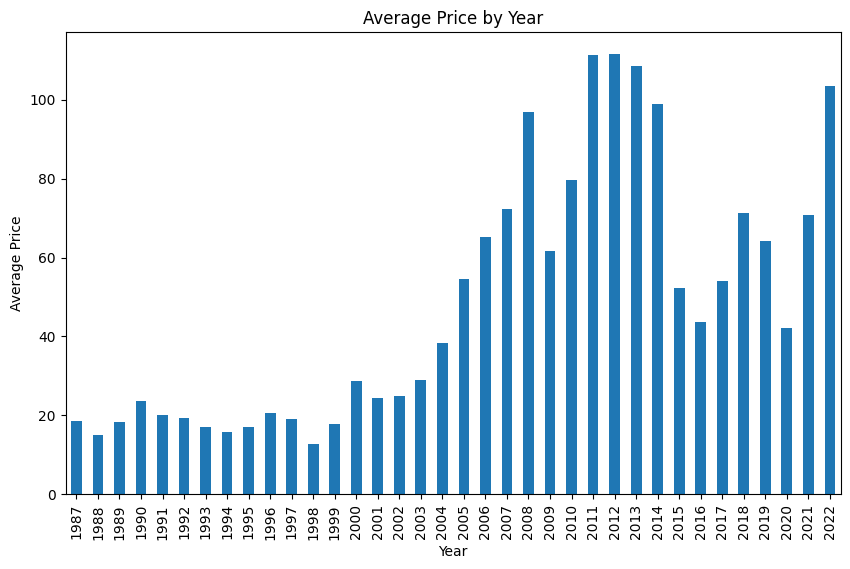

In [12]:
# Bar Chart: Average Price by Year
average_price_by_year = data.groupby('Year')['Price'].mean()
plt.figure(figsize=(10, 6))
average_price_by_year.plot(kind='bar')
plt.title('Average Price by Year')
plt.xlabel('Year')
plt.ylabel('Average Price')
plt.show()

In [13]:
# Descriptive Statistics
mean_price = data['Price'].mean()
median_price =  data['Price'].median()
std_price =  data['Price'].std()

print("Descriptive Statistics:")
print(f"Mean: {mean_price:.2f}")
print(f"Median: {median_price:.2f}")
print(f"Standard Deviation: {std_price:.2f}")

Descriptive Statistics:
Mean: 48.42
Median: 38.57
Standard Deviation: 32.86


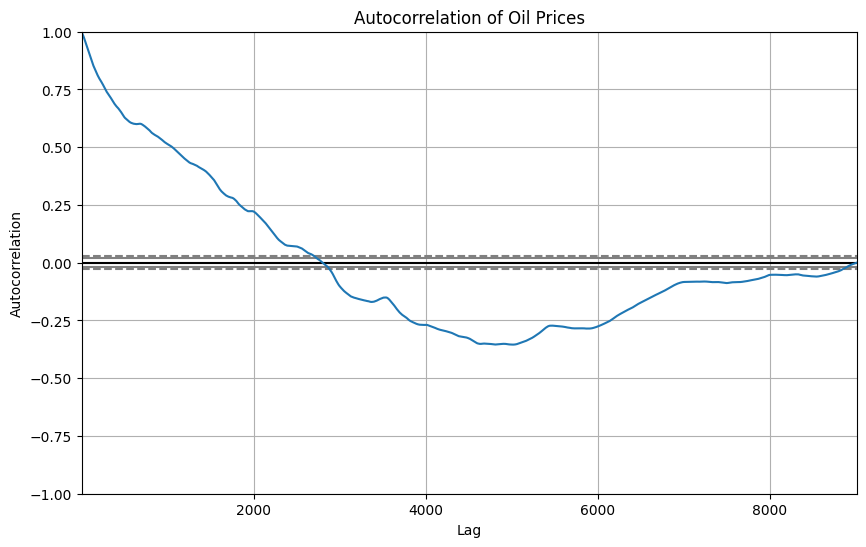

In [14]:
from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(10, 6))
autocorrelation_plot(data['Price'])
plt.title('Autocorrelation of Oil Prices')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Model Building:

- Construct a diverse set of models, ranging from traditional econometric methods to modern machine learning algorithms. Tailor model selection based on the specific characteristics of the data.

# Model Evaluation:

- Evaluate model performance using metrics like RMSE, MAE, and R-squared. Compare models to determine which ones yield the most accurate and interpretable predictions.

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [16]:
class OilPriceAnalysis:
    def __init__(self, data):
        self.data = data

    def seasonal_decomposition(self):
        # Decompose the time series to analyze trend and seasonality
        decomposition = seasonal_decompose(self.data['Price'], model='additive', period=30)
        
        # Plot the decomposition
        plt.figure(figsize=(14, 10))
        decomposition.plot()
        plt.suptitle("Seasonal Decomposition of Brent Oil Prices", fontsize=14)
        plt.show()

<Figure size 1400x1000 with 0 Axes>

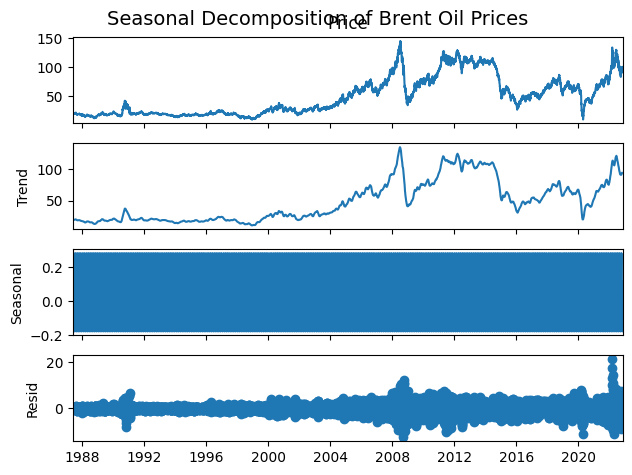

In [17]:
# Instantiate the class and run the decomposition
analysis = OilPriceAnalysis(data)
analysis.seasonal_decomposition()

## Change Point Analysis

#### Step-by-Step Explanation of Change Point Analysis


##### Prepare the Data:

- Extract the Series: The code extracts the 'Price' column from the self.data DataFrame and converts it to a numpy array, which is easier to process with change point detection algorithms.

- Data Format: The time series data should be properly formatted, sorted by date, and free from missing values to ensure the analysis is accurate.

#### Select the Model:

The model defines how the change points will be detected. Common models include:
'rbf': A kernel-based method often used for data with non-linear trends.
Other models could include 'l1' or 'normal' depending on the nature of the data.
Here, the model 'rbf' is selected, suitable for capturing non-linear changes in the data.

#### Detect Change Points:

- The predict() method is used to identify change points. The pen parameter controls the penalty for adding change points:
    - A higher penalty results in fewer detected change points, making the analysis stricter.
    - A lower penalty allows for more detected change points, making it more sensitive.
- Here, the penalty is set to 15. This can be adjusted based on the desired granularity.

In [18]:
import ruptures as rpt

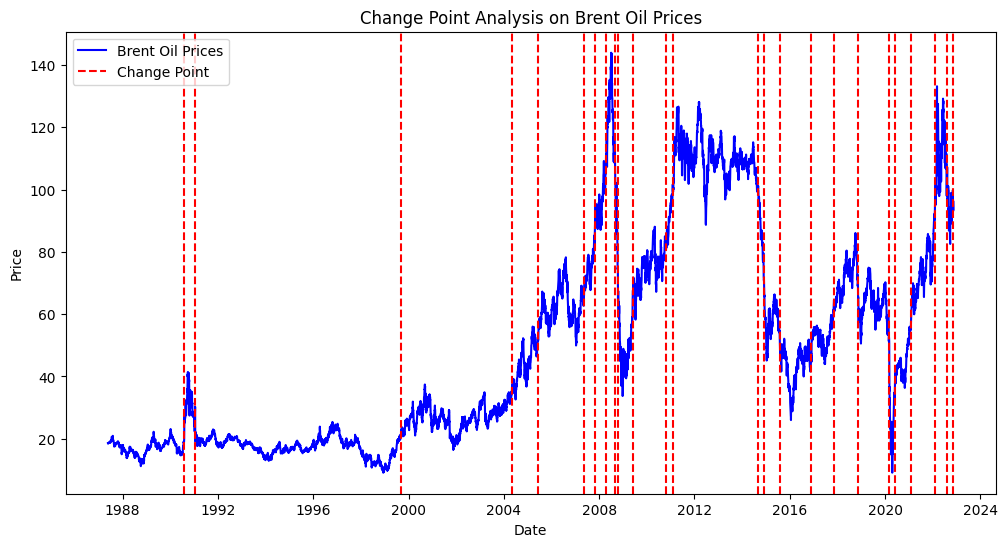

In [19]:
# Ensure you have a 'Price' column for the Brent oil prices
class OilPriceAnalysis:
    def __init__(self, data):
        self.data = data

    def change_point_analysis(self):
        # Prepare the price data as an array
        price_series = self.data['Price'].values

        # Define the model as 'rbf' for kernel-based change point detection
        model = "rbf"
        algo = rpt.Pelt(model=model).fit(price_series)

        # Increase the penalty to reduce the number of change points
        change_points = algo.predict(pen=15)  # Adjust the penalty as needed

        # Plotting the results
        plt.figure(figsize=(12, 6))
        plt.plot(self.data.index, price_series, label="Brent Oil Prices", color='blue')

        # Plot each change point, with only one label in the legend
        for i, cp in enumerate(change_points):
            if i == 0:  # Add label only for the first change point
                plt.axvline(self.data.index[cp - 1], color='red', linestyle='--', label="Change Point")
            else:
                plt.axvline(self.data.index[cp - 1], color='red', linestyle='--')

        plt.legend()
        plt.title("Change Point Analysis on Brent Oil Prices")
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.show()

# Instantiate the class and perform change point analysis
analysis = OilPriceAnalysis(data)
analysis.change_point_analysis()

#### Visualize the Change Points:

- Plot the Original Time Series: The Brent oil prices are plotted using the date index and the price series.

- Plot the Change Points: Vertical dashed red lines are added to indicate where change points are detected.

- Labeling: Only the first change point is labeled for clarity, and subsequent change points are marked without labels to keep the plot clean.

### Interpretation
- Change points are instances in a time series where the statistical properties of the data change abruptly. In the context of Brent oil prices, these could be caused by factors such as:

    - Geopolitical events: Wars, political instability, sanctions, etc.
    - Economic shocks: Recessions, financial crises, changes in interest rates, etc.• Supply disruptions: Natural disasters, production outages, OPEC decisions, etc.
    - Technological advancements: Fracking revolution, renewable energy adoption, etc.

In [20]:
from pmdarima import auto_arima

In [21]:
# Differencing to make the series stationary
data['Price_diff'] = data['Price'].diff().dropna()

# Fit ARIMA model
model = auto_arima(data['Price_diff'].dropna(), seasonal=False, trace=True)
model.summary()

# Fit model with ARIMA parameters
arima_model = ARIMA(data['Price'], order=(5, 1, 0))
arima_result = arima_model.fit()
print(arima_result.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=29075.828, Time=6.65 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=29098.172, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=29094.409, Time=0.26 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=29094.124, Time=0.39 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=29093.231, Time=2.32 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=29093.013, Time=2.96 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=8.02 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=8.94 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=29093.899, Time=0.74 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=29094.073, Time=5.53 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=29094.084, Time=4.44 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=29077.815, Time=19.56 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=29077.401, Time=21.34 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0]          
Total fit time: 81.289 seconds


c:\Users\Hello\Desktop\Html-Tutorial\Document\KAIM-Courses\Week-10_BrentOilPrice\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Hello\Desktop\Html-Tutorial\Document\KAIM-Courses\Week-10_BrentOilPrice\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Hello\Desktop\Html-Tutorial\Document\KAIM-Courses\Week-10_BrentOilPrice\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 9011
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -14540.613
Date:                Tue, 05 Nov 2024   AIC                          29093.226
Time:                        00:24:47   BIC                          29135.862
Sample:                             0   HQIC                         29107.733
                               - 9011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0260      0.006      4.344      0.000       0.014       0.038
ar.L2         -0.0235      0.006     -4.231      0.000      -0.034      -0.013
ar.L3         -0.0071      0.005     -1.507      0.1

In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error,r2_score

# Calculate metrics
# Predictions
pred = arima_result.predict(start=len(data), end=len(data) + 30, typ='levels')
mse = mean_squared_error(data['Price'][-30:], pred[:30])
mae = mean_absolute_error(data['Price'][-30:], pred[:30])
rmse = np.sqrt(mse)
r2_score = r2_score(data['Price'][-30:], pred[:30])
mape = mean_absolute_percentage_error(data['Price'][-30:], pred[:30]) * 100

# Print metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R Square Score (r2_score):", rmse)
print("Mean Absolute Percentage Error (MAPE):", mape, "%")

Mean Absolute Error (MAE): 2.0516119498818526
Mean Squared Error (MSE): 6.927581933434569
Root Mean Squared Error (RMSE): 2.63203000238116
R Square Score (r2_score): 2.63203000238116
Mean Absolute Percentage Error (MAPE): 2.151038469289115 %


c:\Users\Hello\Desktop\Html-Tutorial\Document\KAIM-Courses\Week-10_BrentOilPrice\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Hello\Desktop\Html-Tutorial\Document\KAIM-Courses\Week-10_BrentOilPrice\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Hello\Desktop\Html-Tutorial\Document\KAIM-Courses\Week-10_BrentOilPrice\venv\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


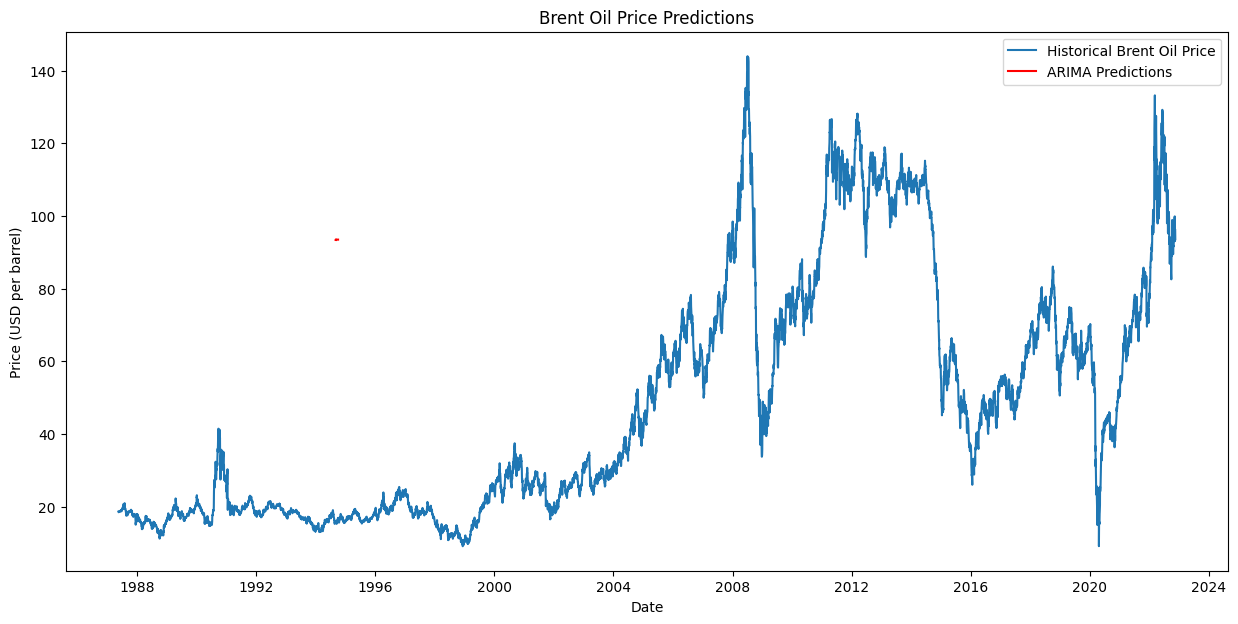

In [24]:
# Plot predictions
plt.figure(figsize=(15, 7))
plt.plot(data['Price'], label='Historical Brent Oil Price')
plt.plot(pred, label='ARIMA Predictions', color='red')
plt.xlabel('Date')
plt.ylabel('Price (USD per barrel)')
plt.title('Brent Oil Price Predictions')
plt.legend()
plt.show()

In [25]:
# Example: Identify significant events and their impact on oil prices
significant_events = {
    "1990-08-02": "Iraq invades Kuwait, triggering a major global oil crisis",
    "2001-09-11": "September 11 terrorist attacks in the US, causing market disruptions",
    "2003-03-20": "US-led invasion of Iraq begins, creating significant oil supply concerns",
    "2005-08-29": "Hurricane Katrina severely disrupts US Gulf Coast oil production",
    "2008-07-11": "Oil prices hit a historic high of $147 per barrel amid global demand concerns",
    "2008-09-15": "Collapse of Lehman Brothers, leading to a major global financial crisis",
    "2011-02-15": "Libyan Civil War disrupts significant oil exports, affecting prices",
    "2012-05-18": "International sanctions on Iran reduce global oil supply, impacting markets",
    "2014-06-24": "Geopolitical tensions in Iraq influence oil market stability",
    "2016-11-30": "OPEC and allies agree to production cuts, supporting oil price recovery",
    "2019-09-14": "Drone attacks on Saudi oil facilities disrupt global supply, spiking prices",
    "2020-03-20": "Oil demand collapses as COVID-19 pandemic worsens globally",
    "2020-04-20": "Historic crash in oil prices; WTI futures go negative for the first time",
    "2022-02-24": "Russia's invasion of Ukraine causes a surge in oil prices due to supply fears"
}

for date, event in significant_events.items():
    date = pd.to_datetime(date)
    if date in data.index:
        prev_date = date - pd.Timedelta(days=1)
        if prev_date in data.index:
            price_change = data.loc[date]['Price'] - data.loc[prev_date]['Price']
            print(f"Event: {event} on {date.strftime('%Y-%m-%d')}")
            print(f"Price Change: {price_change:.2f}\n")
        else:
            print(f"Previous day's data not available for event: {event} on {date.strftime('%Y-%m-%d')}\n")
    else:
        print(f"Data not available for event: {event} on {date.strftime('%Y-%m-%d')}\n")

Event: Iraq invades Kuwait, triggering a major global oil crisis on 1990-08-02
Price Change: 2.32

Event: September 11 terrorist attacks in the US, causing market disruptions on 2001-09-11
Price Change: 1.53

Event: US-led invasion of Iraq begins, creating significant oil supply concerns on 2003-03-20
Price Change: -0.40

Previous day's data not available for event: Hurricane Katrina severely disrupts US Gulf Coast oil production on 2005-08-29

Event: Oil prices hit a historic high of $147 per barrel amid global demand concerns on 2008-07-11
Price Change: 7.87

Previous day's data not available for event: Collapse of Lehman Brothers, leading to a major global financial crisis on 2008-09-15

Event: Libyan Civil War disrupts significant oil exports, affecting prices on 2011-02-15
Price Change: -0.64

Event: International sanctions on Iran reduce global oil supply, impacting markets on 2012-05-18
Price Change: -1.28

Event: Geopolitical tensions in Iraq influence oil market stability on 2

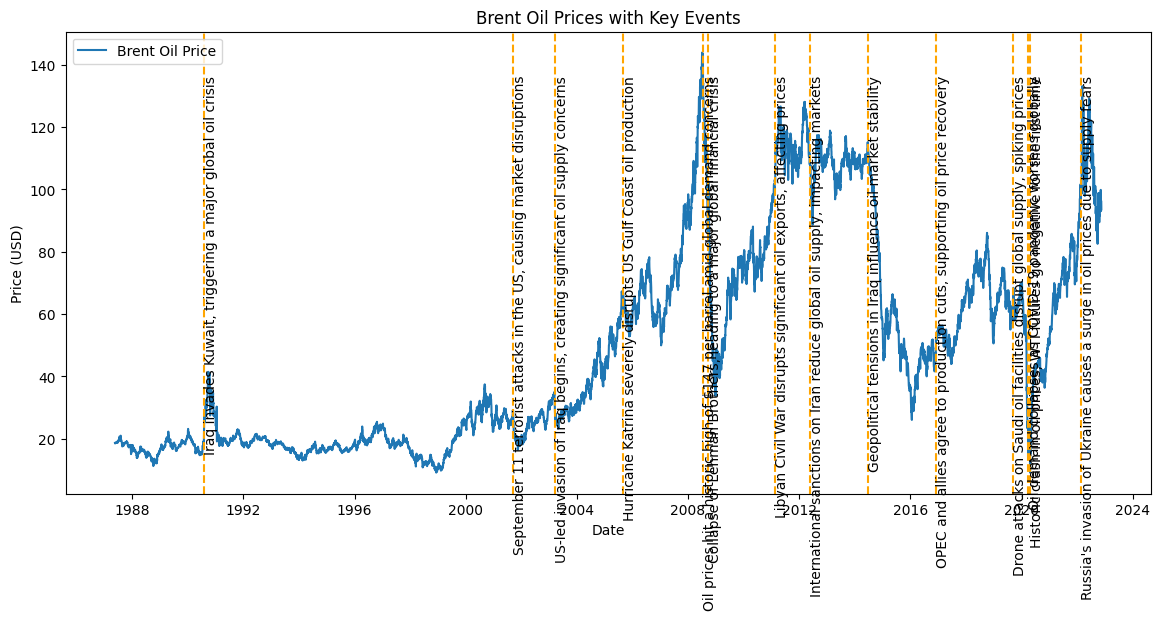

In [26]:
# Plot events on price time series
plt.figure(figsize=(14, 6))
plt.plot(data.index, data['Price'], label='Brent Oil Price')
for date, label in significant_events.items():
    plt.axvline(pd.to_datetime(date), color='orange', linestyle='--')
    plt.text(pd.to_datetime(date), data['Price'].max()*0.95, label, rotation=90, verticalalignment='top')
plt.title("Brent Oil Prices with Key Events")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()


In [27]:
# Example GARCH model (requires ARCH package)
from arch import arch_model

# Fit a GARCH model
garch_model = arch_model(data['Price'], vol='Garch', p=1, q=1)
garch_result = garch_model.fit()
print(garch_result.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3874927804.158277
Iteration:      2,   Func. Count:     12,   Neg. LLF: 70148.68734205695
Iteration:      3,   Func. Count:     19,   Neg. LLF: 924509187.1107914
Iteration:      4,   Func. Count:     27,   Neg. LLF: 44099.26204018903
Iteration:      5,   Func. Count:     33,   Neg. LLF: 41882.581755042986
Iteration:      6,   Func. Count:     39,   Neg. LLF: 41190.23335963133
Iteration:      7,   Func. Count:     46,   Neg. LLF: 40221.97253756566
Iteration:      8,   Func. Count:     52,   Neg. LLF: 38675.84139852016
Iteration:      9,   Func. Count:     58,   Neg. LLF: 46507.19984815386
Iteration:     10,   Func. Count:     64,   Neg. LLF: 52311.49939565074
Iteration:     11,   Func. Count:     73,   Neg. LLF: 39566.28900289833
Iteration:     12,   Func. Count:     79,   Neg. LLF: 37683.04414723057
Iteration:     13,   Func. Count:     85,   Neg. LLF: 38550.85348090723
Iteration:     14,   Func. Count:     91,   Neg. LLF: 48052.343

## LSTM (Long Short-Term Memory) :
- networks for capturing complex patterns and dependencies in the data.


In [30]:
import os
import warnings
warnings.filterwarnings("ignore")
notebook_dir = os.getcwd()
parent_path=os.path.dirname(notebook_dir)

os.chdir(parent_path)

In [32]:
from scripts.LSTM_modeling import LSTM_Modelling
lstm=LSTM_Modelling()

In [28]:
import tensorflow as tf
print(tf.__version__)

2.18.0


In [33]:
import pandas as pd
data=pd.read_csv("data/brent_oil_priceS.csv")
data.head()

,Date,Price
0,20-May-87,18.63
1,21-May-87,18.45
2,22-May-87,18.55
3,25-May-87,18.60
4,26-May-87,18.63


In [35]:
test_data,y_test,y_pred=lstm.train_lstm(data,'lstm')

Epoch 1/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 26s 93ms/step - loss: 0.0097 - val_loss: 9.6706e-04
Epoch 2/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 18s 81ms/step - loss: 0.0015 - val_loss: 7.7792e-04
Epoch 3/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 19s 83ms/step - loss: 0.0014 - val_loss: 6.3271e-04
Epoch 4/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 18s 82ms/step - loss: 0.0013 - val_loss: 5.6540e-04
Epoch 5/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 18s 82ms/step - loss: 0.0010 - val_loss: 5.5166e-04
Epoch 6/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 18s 80ms/step - loss: 9.7202e-04 - val_loss: 6.0646e-04
Epoch 7/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 19s 86ms/step - loss: 7.9948e-04 - val_loss: 5.3739e-04
Epoch 8/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 20s 89ms/step - loss: 7.4911e-04 - val_loss: 4.7192e-04
Epoch 9/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 20s 88ms/step - loss: 7.7150e-04 - val_loss: 6.5356e-04
Epoch 10/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 20s 88ms/step - loss: 7.2276e-04 - val_loss: 4.9196e-04
224/224 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step
55/55 ━━━━━━━━━━━

PermissionError: [Errno 13] Permission denied: '/modelslstm-05-11-2024-01-23-21-00.pkl'

In [ ]:
lstm.evaluate_lstm_model(y_test,y_pred)

In [ ]:
lstm.plot_result(y_test,y_pred)